In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

Using TensorFlow backend.


In [3]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth

from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

train_link = 'https://drive.google.com/open?id=12yJ18XyODGPMCUwncNzdaKHFbf3eFIo6'
fluff, id = train_link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv') 

    100% |████████████████████████████████| 993kB 24.5MB/s 


In [0]:
df = pd.read_csv('train.csv')

In [0]:
df.columns = ["S.N.","Contract No", "Stock Symbol", "Buyer Broker", "Seller Broker", "Quantity", "Rate", "Amount", "Junk"]
df.drop('Junk', 1, inplace = True)
df.drop_duplicates(subset = ['Contract No'], keep = False)
df.sort_values('Contract No',inplace = True)

In [0]:
amount = np.array(df['Amount'])
df = df[df['Contract No'] > 200711220020530]

buyer_broker = np.array(df['Buyer Broker'])
seller_broker = np.array(df['Seller Broker'])
quantity = np.array(df['Quantity'])
rate = np.array(df['Rate'])

In [0]:
#
#Closing Stock Formula (Ending) = Opening Stock + Purchases – Cost of Goods Sold

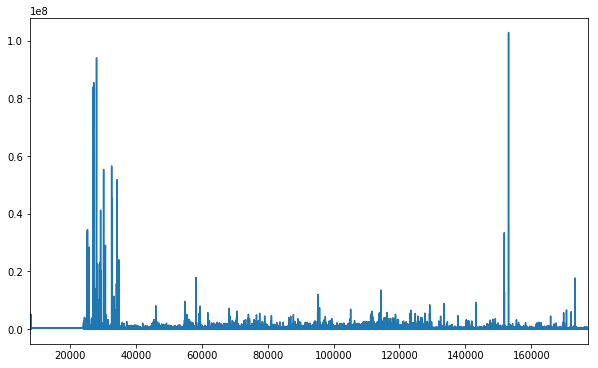

In [8]:
plt.figure(figsize=(10, 6))
df['Amount'].plot()
ndf = df[:]

<Figure size 720x432 with 0 Axes>

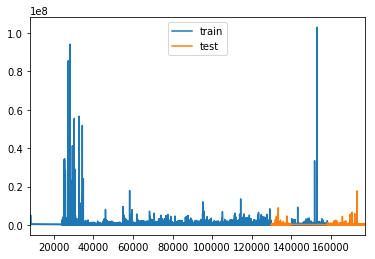

In [9]:
check = 'Amount'

train = df.loc[:139685]
train = pd.DataFrame(train[check])
test = df.loc[139685:]
test = pd.DataFrame(test[check])

plt.figure(figsize=(10, 6))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test']);

In [0]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

In [0]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [13]:
'''
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()
'''

  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 419.1 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


In [15]:
##NN

nn_model = Sequential()
nn_model.add(Dense(12, input_dim=1, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = nn_model.fit(X_train, y_train, epochs=7, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/7
124550/124550 [==============================] - 261s 2ms/step - loss: 3.4567e-04
Epoch 2/7
124550/124550 [==============================] - 260s 2ms/step - loss: 3.2977e-04
Epoch 3/7
124550/124550 [==============================] - 262s 2ms/step - loss: 3.3448e-04
Epoch 4/7
124550/124550 [==============================] - 259s 2ms/step - loss: 3.3039e-04
Epoch 00004: early stopping


In [16]:
y_pred_test_nn = nn_model.predict(X_test)
y_train_pred_nn = nn_model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))

The R2 score on the Train set is:	-0.025
The R2 score on the Test set is:	-0.083


In [17]:
## LSTM

train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.as_matrix()
y_train = y_train.as_matrix()

X_test = X_test.as_matrix()
y_test = y_test.as_matrix()



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [18]:
X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('Train shape: ', X_train_lmse.shape)
print('Test shape: ', X_test_lmse.shape)

Train shape:  (124550, 1, 1)
Test shape:  (28786, 1, 1)


In [19]:
lstm_model = Sequential()
lstm_model.add(LSTM(7, input_shape=(1, X_train_lmse.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=10, batch_size=10, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/10
124550/124550 [==============================] - 58s 466us/step - loss: 0.0261
Epoch 2/10
124550/124550 [==============================] - 58s 465us/step - loss: 3.1375e-04
Epoch 3/10
124550/124550 [==============================] - 57s 460us/step - loss: 3.1153e-04
Epoch 4/10
124550/124550 [==============================] - 56s 452us/step - loss: 3.0971e-04
Epoch 5/10
124550/124550 [==============================] - 58s 467us/step - loss: 3.0853e-04
Epoch 6/10
124550/124550 [==============================] - 59s 473us/step - loss: 3.0758e-04
Epoch 7/10
124550/124550 [==============================] - 58s 468us/step - loss: 3.0688e-04
Epoch 8/10
124550/124550 [==============================] - 59s 470us/step - loss: 3.0650e-04
Epoch 9/10
124550/124550 [==============================] - 58s 466us/step - loss: 3.0621e-04
Epoch 10/10
124550/124550 [==============================] - 57s 462us/step - loss: 3.0606e-04


In [20]:
y_pred_test_lstm = lstm_model.predict(X_test_lmse)
y_train_pred_lstm = lstm_model.predict(X_train_lmse)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))

The R2 score on the Train set is:	0.069
The R2 score on the Test set is:	-0.006


In [21]:
nn_test_mse = nn_model.evaluate(X_test, y_test, batch_size=1)
lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=1)
print('NN: %f'%nn_test_mse)
print('LSTM: %f'%lstm_test_mse)

28786/28786 [==============================] - 49s 2ms/step
NN: 0.000012
LSTM: 0.000011


In [0]:
print(nn_test_mse, lstm_test_mse)


In [0]:
nn_y_pred_test = nn_model.predict(X_test)
lstm_y_pred_test = lstm_model.predict(X_test_lmse)

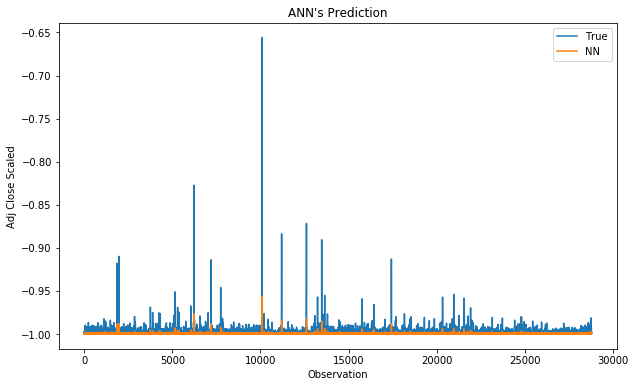

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_nn, label='NN')
plt.title("ANN's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close Scaled')
plt.legend()
plt.show();

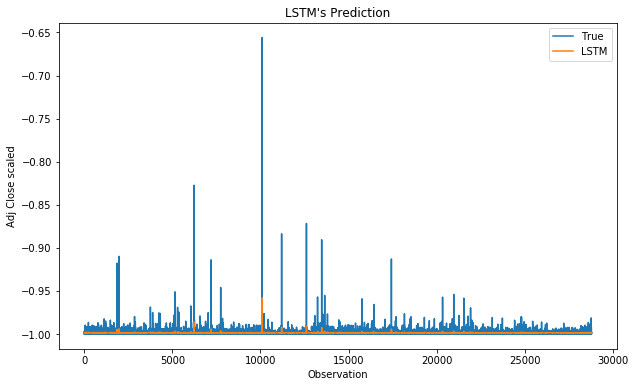

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close scaled')
plt.legend()
plt.show();